import libraries and read data

In [13]:
# we have to install the development version for the time being
#!pip uninstall eodal -y
#!pip install git+https://github.com/lukasValentin/eodal@landsat-dev

#!pip install --upgrade git+https://github.com/EOA-team/eodal
#!pip install --upgrade planetary-computer

# Print EOdal version
#import eodal
#print("Version of EOdal: " + eodal.__version__)

In [14]:
# Import general libraries
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

# Import EOdal libraries
from eodal.core.band import Band
from eodal.core.raster import RasterCollection

# Import scikit-learn libraries
import sklearn
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler

In [15]:
#year to cluster
year = 2021

In [16]:
#read tif from disk:
fpath_raster = Path(f'S:\MSc_23_TimckeFinn\data\EOdal\landsat_median_composite_{year}_smallAOI.tif')

# initialize a RasterCollection from the .tif file
composite = RasterCollection.from_multi_band_raster(fpath_raster=fpath_raster,
                                                    band_names_dst= ['blue_median','green_median','red_median','nir08_median','swir16_median','swir22_median'],
                                                    band_aliases = ["blue", "green", "red", "nir_1", "swir_1","swir_2"])

# calculate some SI
composite.calc_si('NDVI', inplace = True)
composite.calc_si('NDWI', inplace = True)
composite.calc_si('EVI', inplace = True)
composite.calc_si('CI_GREEN', inplace = True)
composite.calc_si('MSAVI', inplace = True)
composite.calc_si('BSI', inplace = True)

# print band summaries
composite.band_summaries()

,min,mean,std,max,count,geometry,band_name
0,0.076900,1.765055e+17,4.197547e+18,1.000000e+20,306506.0,"POLYGON ((883934.373 44724.196, 883934.373 586...",blue_median
1,0.081770,1.765055e+17,4.197547e+18,1.000000e+20,306506.0,"POLYGON ((883934.373 44724.196, 883934.373 586...",green_median
2,0.077590,1.765055e+17,4.197547e+18,1.000000e+20,306506.0,"POLYGON ((883934.373 44724.196, 883934.373 586...",red_median
3,0.086340,1.765055e+17,4.197547e+18,1.000000e+20,306506.0,"POLYGON ((883934.373 44724.196, 883934.373 586...",nir08_median
4,0.077655,1.765055e+17,4.197547e+18,1.000000e+20,306506.0,"POLYGON ((883934.373 44724.196, 883934.373 586...",swir16_median
5,0.075740,1.765055e+17,4.197547e+18,1.000000e+20,306506.0,"POLYGON ((883934.373 44724.196, 883934.373 586...",swir22_median
6,0.000000,3.572773e-01,4.943599e-02,4.941866e-01,306506.0,"POLYGON ((883934.373 44724.196, 883934.373 586...",NDVI
7,-0.455743,-3.313984e-01,4.749607e-02,2.541758e-02,306506.0,"POLYGON ((883934.373 44724.196, 883934.373 586...",NDWI
8,-0.000000,2.179272e-01,3.752961e-02,3.618177e-01,306506.0,"POLYGON ((883934.373 44724.196, 883934.373 586...",EVI
9,-0.049575,1.003554e+00,1.757459e-01,1.674734e+00,306506.0,"POLYGON ((883934.373 44724.196, 883934.373 586...",CI_GREEN


In [17]:
# Create a DataFrame from the RasterCollection
gdf = composite.to_dataframe()

gdf.head()

,geometry,blue_median,green_median,red_median,nir08_median,swir16_median,swir22_median,NDVI,NDWI,EVI,CI_GREEN,MSAVI,BSI
0,POINT (864061.229 58623.388),1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
1,POINT (864061.229 58593.368),8.364000e-02,9.259000e-02,8.802000e-02,1.819300e-01,1.278800e-01,1.032700e-01,0.347879,-0.325441,0.216832,0.964899,0.155424,-0.103163
2,POINT (864061.229 58563.349),8.334000e-02,9.273000e-02,8.986000e-02,1.709900e-01,1.284000e-01,1.029200e-01,0.311022,-0.296754,0.186918,0.843956,0.134364,-0.076324
3,POINT (864061.229 58533.329),8.118000e-02,9.065000e-02,8.649000e-02,1.799200e-01,1.231400e-01,9.795000e-02,0.350700,-0.329933,0.214287,0.984777,0.155105,-0.109341
4,POINT (864061.229 58503.309),8.078000e-02,8.995000e-02,8.461000e-02,1.844200e-01,1.255600e-01,9.707000e-02,0.371000,-0.344316,0.229717,1.050250,0.165950,-0.115762


In [18]:
from sklearn.preprocessing import MinMaxScaler

selected_columns = ['blue_median','green_median','red_median','nir08_median','swir16_median','swir22_median','NDVI','NDWI','EVI','CI_GREEN','MSAVI','BSI']

## Step 1: Extract the feature columns from the GeoDataFrame into a NumPy array
features = gdf[selected_columns].values

## Step 2: Initialize the MinMaxScaler
scaler = MinMaxScaler()

## Step 3: Fit the scaler to the feature data
scaler.fit(features)

## Step 4: Transform the feature data using the fitted scaler
scaled_features = scaler.transform(features)

## Step 5: Replace the original feature values in the GeoDataFrame with the scaled values
gdf[selected_columns] = scaled_features

gdf[selected_columns].head()

,blue_median,green_median,red_median,nir08_median,swir16_median,swir22_median,NDVI,NDWI,EVI,CI_GREEN,MSAVI,BSI
0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.947174,0.000000,0.028751,0.000000,0.716328
1,6.740004e-23,1.081999e-22,1.042999e-22,9.559000e-22,5.022501e-22,2.753000e-22,0.703943,0.270808,0.599286,0.588337,0.577862,0.362346
2,6.439999e-23,1.096000e-22,1.227000e-22,8.465000e-22,5.074500e-22,2.718000e-22,0.629361,0.330428,0.516609,0.518196,0.499561,0.454439
3,4.280001e-23,8.879997e-23,8.899994e-23,9.358000e-22,4.548500e-22,2.221000e-22,0.709651,0.261472,0.592251,0.599865,0.576675,0.341149
4,3.880002e-23,8.180000e-23,7.019997e-23,9.808000e-22,4.790500e-22,2.133000e-22,0.750728,0.231579,0.634896,0.637835,0.616999,0.319115


In [19]:
# Get the colors from the "Accent" colormap
cmap = plt.get_cmap('Accent')
colors = cmap.colors
values = np.arange(8)

c:\Users\ftimcke\AppData\Local\anaconda3\envs\lulc\Lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)


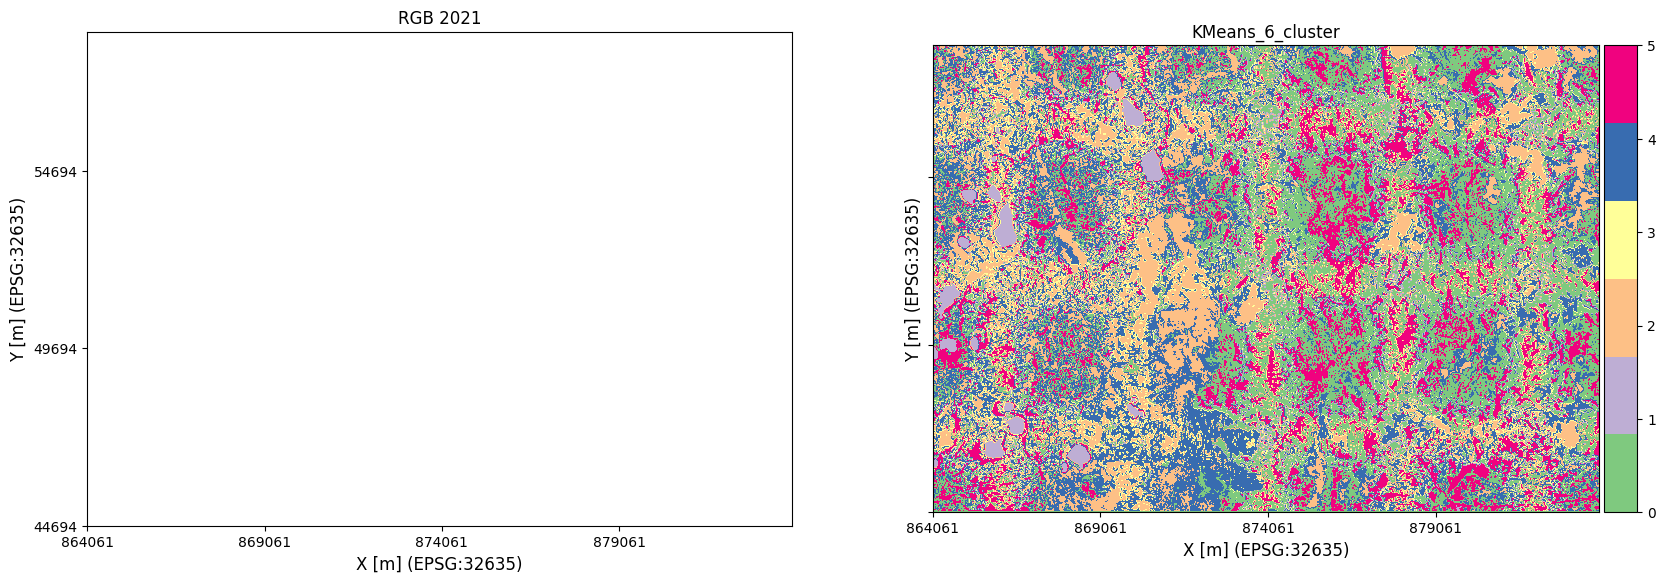

In [20]:
## Use K-means for Clustering:

# set the desired number of clusters for KMean and GMM

for n in range(6, 7, 1):

    # create model
    km = KMeans(n_clusters = n, n_init = 'auto') 

    # fit the model to the data
    km.fit(scaled_features)

    # Get the cluster labels
    labels = km.labels_

    # Calculate the scores
    #silhouette = silhouette_score(scaled_features, labels)
    #calinski_harabasz = calinski_harabasz_score(scaled_features, labels)
    #davies_bouldin = davies_bouldin_score(scaled_features, labels)

    # Print the scores
    #print(f'kmeans, {n}, Silhouette score, {silhouette}')
    #print(f'kmeans, {n}, Calinski-Harabasz score, {calinski_harabasz}')
    #print(f'kmeans, {n}, Davies-Bouldin score, {davies_bouldin}')

    # Add the cluster labels to the DataFrame and show it
    gdf[f'KMeans_{n}_cluster'] = labels
        
    # create new band instance from a column in GeoDataFrame
    KMeans_cluster = Band.from_vector(vector_features = gdf,
                                 band_name_src = f'KMeans_{n}_cluster',
                                 geo_info = composite['blue'].geo_info,
                                 band_name_dst = f'KMeans_{n}_cluster'
                                 )

    #add column KMeans_cluster as a new Band into the RasterCollection composite
    composite.add_band(KMeans_cluster)
    
    #plot clusters
    fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)
    cmap = plt.cm.colors.ListedColormap(colors[:n])
    ticks = list(range(n))

    composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
    axs[0].set_title(f'RGB {year}')

    composite.plot_band(f'KMeans_{n}_cluster', colormap=cmap, discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
    axs[1].set_title(f'KMeans_{n}_cluster')
    
    #save as PNG for quick view
    fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\KMeans_{n}_cluster_{year}.png')


In [21]:
## Use Spectral Clustering for Clustering:

from sklearn.cluster import SpectralClustering

for n in range(6, 7, 1):
    
    # Assuming 'scaled_features' is your scaled data array
    # You need to set the appropriate values for these parameters
    n_clusters = n  # Number of clusters you want to find
    affinity_matrix = 'nearest_neighbors'  # Type of affinity matrix ('nearest_neighbors' or 'rbf')
    random_state = 42  # Random state for reproducibility

    # Create a SpectralClustering instance
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity=affinity_matrix, random_state=random_state)

    # Fit and predict the clusters
    cluster_labels = spectral_clustering.fit_predict(scaled_features)

    print("Cluster labels:", cluster_labels)

    # Assign cluster labels to GeoDataFrame
    gdf[f'Spectral_{n_clusters}_cluster'] = cluster_labels

    # create new band instance from a column in GeoDataFrame
    Spectral_cluster = Band.from_vector(vector_features = gdf,
                                    band_name_src = f'Spectral_{n_clusters}_cluster',
                                    geo_info = composite['blue'].geo_info,
                                    band_name_dst = f'Spectral_{n_clusters}_cluster')

    #add column GMM_cluster as a new Band into the RasterCollection composite
    composite.add_band(Spectral_cluster)

    #plot clusters
    fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)
    cmap = plt.cm.colors.ListedColormap(colors[:n_clusters])
    ticks = list(range(n_clusters))

    composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
    axs[0].set_title(f'RGB {year}')

    composite.plot_band(f'Spectral_{n_clusters}_cluster', colormap=cmap, discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
    axs[1].set_title(f'Spectral_{n_clusters}_cluster')

    #save as PNG for quick view
    fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\Spectral_{n_clusters}_cluster_{year}.png')

c:\Users\ftimcke\AppData\Local\anaconda3\envs\lulc\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


c:\Users\ftimcke\AppData\Local\anaconda3\envs\lulc\Lib\site-packages\eodal\core\band.py:1637: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(user_defined_ticks)


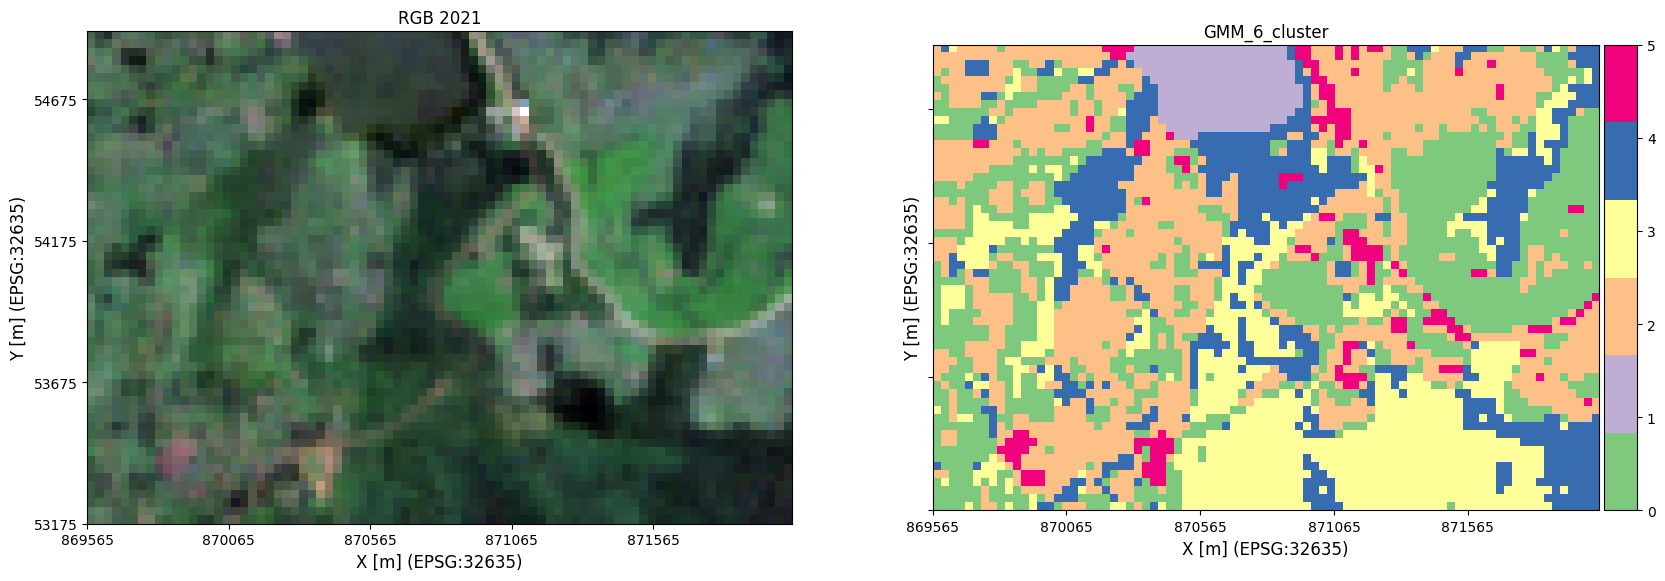

In [ ]:
## Use Gaussian Mixture Models for Clustering:

for n in range(6, 7, 1):

    # create model
    gmm = GaussianMixture(n_components = n)

    # fit the model to the data
    gmm.fit(scaled_features)

    # Assign cluster labels
    GMM_cluster = gmm.predict(scaled_features)

    # Calculate the scores
    #silhouette = silhouette_score(scaled_features, labels)
    #calinski_harabasz = calinski_harabasz_score(scaled_features, labels)
    #davies_bouldin = davies_bouldin_score(scaled_features, labels)

    # Print the scores
    #print(f'gmm, {n}, Silhouette score, {silhouette}')
    #print(f'gmm, {n}, Calinski-Harabasz score, {calinski_harabasz}')
    #print(f'gmm, {n}, Davies-Bouldin score, {davies_bouldin}')

    # Assign cluster labels to GeoDataFrame
    gdf[f'GMM_{n}_cluster'] = GMM_cluster

    # create new band instance from a column in GeoDataFrame
    GMM_cluster = Band.from_vector(vector_features = gdf,
                                    band_name_src = f'GMM_{n}_cluster',
                                    geo_info = composite['blue'].geo_info,
                                    band_name_dst = f'GMM_{n}_cluster')

    #add column GMM_cluster as a new Band into the RasterCollection composite
    composite.add_band(GMM_cluster)
    
    #plot clusters
    fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)
    cmap = plt.cm.colors.ListedColormap(colors[:n])
    ticks = list(range(n))

    composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
    axs[0].set_title(f'RGB {year}')

    composite.plot_band(f'GMM_{n}_cluster', colormap=cmap, discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
    axs[1].set_title(f'GMM_{n}_cluster')
    
    #save as PNG for quick view
    fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\GMM_{n}_cluster_{year}.png')

In [ ]:
""" ## Use MeanShift for Clustering:
from sklearn.cluster import estimate_bandwidth

bandwidth_est = estimate_bandwidth(scaled_features)
print(f'estimated bandwidth: {bandwidth_est}')

#define bandwidth for model
bandwidth = 0.3

# create model
ms = MeanShift(bandwidth=bandwidth)

# fit the model to the data
ms.fit(scaled_features)

# Assign cluster labels
cluster_labels = ms.labels_

# Assign cluster labels to GeoDataFrame
gdf[f'MeanShift_cluster_{bandwidth}'] = cluster_labels

# add column cluster_mean_shift as a new Band into the RasterCollection composite
MeanShift_cluster = Band.from_vector(vector_features = gdf,
                                band_name_src = f'MeanShift_cluster_{bandwidth}',
                                geo_info = composite['blue'].geo_info,
                                band_name_dst=f'MeanShift_cluster_{bandwidth}')

#composite.add_band(MeanShift_cluster)

#plot clusters
fig, axs = plt.subplots(1, 2, figsize = (20, 10), sharey=True)

composite.plot_multiple_bands(["red", "green", "blue"], ax=axs[0])
axs[0].set_title(f'RGB {year}')

composite.plot_band(f'MeanShift_cluster_{bandwidth}', colormap='Accent', discrete_values = False, user_defined_ticks = ticks, ax=axs[1])
axs[1].set_title(f'MeanShift_cluster with bandwith: {bandwidth}')

#save as PNG for quick view
fig.savefig(f'S:\MSc_23_TimckeFinn\data\python_outputs\cluster\MS_cluster_{year}_{bandwidth}.png')
 """

' ## Use MeanShift for Clustering:\nfrom sklearn.cluster import estimate_bandwidth\n\nbandwidth_est = estimate_bandwidth(scaled_features)\nprint(f\'estimated bandwidth: {bandwidth_est}\')\n\n#define bandwidth for model\nbandwidth = 0.3\n\n# create model\nms = MeanShift(bandwidth=bandwidth)\n\n# fit the model to the data\nms.fit(scaled_features)\n\n# Assign cluster labels\ncluster_labels = ms.labels_\n\n# Assign cluster labels to GeoDataFrame\ngdf[f\'MeanShift_cluster_{bandwidth}\'] = cluster_labels\n\n# add column cluster_mean_shift as a new Band into the RasterCollection composite\nMeanShift_cluster = Band.from_vector(vector_features = gdf,\n                                band_name_src = f\'MeanShift_cluster_{bandwidth}\',\n                                geo_info = composite[\'blue\'].geo_info,\n                                band_name_dst=f\'MeanShift_cluster_{bandwidth}\')\n\n#composite.add_band(MeanShift_cluster)\n\n#plot clusters\nfig, axs = plt.subplots(1, 2, figsize = (20, 10

In [ ]:
# save as GeoTiff
composite.to_rasterio(f'S:\MSc_23_TimckeFinn\data\EOdal\landsat_median_composite_{year}_smallAOI_si_cluster.tif')